In [20]:
import sys
import csv
import numpy as np
import matplotlib.pyplot as plt

In [21]:
# reference sound pressure level for airborne sound is 20 micropascals (μPa or e-6)

# https://media.hbkworld.com/m/ac047760baf884bf/original/Sound-Intensity.pdf

db_spl_to_pascal = lambda db: np.power( 10, db/20 ) * 20e-6

pascal_to_db_spl = lambda pa: 20 * np.log10( pa / 20e-6 )  


In [22]:
def timebase_to_sampling_period(timebase: int) -> float:
    """
    Calculates the sampling period (s) based on the timebase

    when the timebase (n) is 9, the picoscope will sample every (9+1) * 10e-7 s = 1 us. 
    when the timebase (n) is 0, the picoscope will sample every (0+1) * 10e-7 s = 0.1 us. 
    """
    return (timebase+1) * 1e-7



def free_field_correction( pressure_rms, correction=0.78 ):
    """
    Free-field correction curves for Bruel & Kjaer Type 4138 from the spec:  

    https://kiptm.ru/images/Production/bruel/table_pdf/microphones_preamps/2017.02/4138.pdf    

    Free-field corrections must be added to the pressure (actuator) response of the microphone in
    order to obtain the free-field response at a particular angle of incidence. 
    
    The free-field correction represents the increase of sound pressure caused by diffraction of the sound waves
    around the microphone and is only significant at very high frequencies where the wavelength
    is comparable with the external dimensions of the microphone.

    The correction value of 0.78 dB for an angle of incidence q = 90 degrees, was obtained with a graphic scanner
    (https://automeris.io/WebPlotDigitizer/) and the graph in the spec sheet above 

    """

    # peak-to-peak amplitude represents the full range between the positive and negative peaks of the waveform.
    # to approximate the RMS value, we divide this peak-to-peak amplitude by the square root of 2

    return db_spl_to_pascal( pascal_to_db_spl(pressure_rms) - correction )

def remove_dc_bias(voltages_peak_to_peak):

    # # remove DC bias
    # if np.max(voltages_peak_to_peak) > np.min(voltages_peak_to_peak):
    #     voltages_peak_to_peak -= dc_bias
    # else: 
    #     voltages_peak_to_peak += dc_bias
    pass


def pressure_rms_from_voltages_peak_to_peak( voltages_peak_to_peak, preamplifier_gain=3.16/1000 ): 
    """
    Calculate pressure Root Mean Square (RMS) from a list of voltage measurements with the BEAST.

    RMS = sqrt( 1/N * sum(p(n)^2) ) 
    
    Args:
        voltages: list of voltages peak-to-peak [V] sampled for a given spatial coordinate 

        preamplifier_gain: user-configured gain [mV/Pa] (e.g. 1mV, 3.16mV)
        
    Returns:
        Pressure RMS for the spatial coordinate
    """
    voltage_rms = np.sqrt(np.mean(np.square(voltages_peak_to_peak)))
    
    pressure_rms = voltage_rms / preamplifier_gain
    
    return pressure_rms


def phase_from_voltages_peak_to_peak( voltages_peak_to_peak, scope_sampling_period ):
    """
    Calculates the phase angle from a list of voltage measurements, 
    
    waveform based on the minimum voltage point within a period of the waveform.

    Depends on sampling period and the number of samples per segment. 
    
    e.g. 
    
    if theses values are 1000 and 0.1 us, the period of each segment is 1000 * 0.1 us = 0.1 ms  
    Thus we get 40 cycles at 40 kHz. 
    
    Args:
        voltage_list: List of voltage peak-to-peak measurements for this data point.

        scope_sampling_period: time in microseconds between voltage samples. 
                                This is dependendent of the timebase set on the Beast GUI.
                                e.g. when the timebase (n) is 9, the picoscope will then sample every (9+1)*10 -7 s = 1 us. 

        samples_per_segment: the number of samples for each segment or point in the field 
        
    Returns:
        Phase measured for a given segment.
        
    """
    
    wave_period = 1/40000                                     # period of a 40 kHz wave, the time taken to complete one cycle, set to .25 us   
    
    samples_per_period = wave_period / scope_sampling_period  # e.g. 25 us / 0.1 us = 250 samples per period

    min_voltage = min(voltages_peak_to_peak)

    # index of minimum voltage adjusted to zero, assuming that the waveform starts at index 0
    min_voltage_zero_index = list(voltages_peak_to_peak).index(min_voltage) - 1

    # mod ensures that the index remains within the range of a single period.
    # we convert the index to an angle in radians by scaling the value to cover 2π radians within a single period
    # we normalizes the angle within the range of 0 to 2π radians, by dividing the scaled value by samples_per_period
    # this ensures that the phase angle is proportional to the relative position of the minimum voltage within a period
    # subtracting π from the normalized angle adjusts the phase angle to be centered around zero [-π, +π] radians
    return 2*np.pi * np.mod( min_voltage_zero_index, samples_per_period ) / samples_per_period - np.pi



In [23]:
class VADProcessor:

    def __init__(self):
        self.x_size = -1 
        self.y_size = -1
        self.z_size = -1
        self.step_size = -1
        self.samples_per_segment = -1
        self.sampling_period = -1
        self.preamplifier_gain = -1
        self.free_field_correction_factor = -1

        self.coords = []
        self.voltages = []
        self.amplitudes = []
        self.phases = []

        self.complex_pressure_field = {}
        return 

    def set_free_field_correction( self, free_field_correction=0.78 ):
        self.free_field_correction_factor = free_field_correction
        return

    def set_preamplifier_gain( self, preamplifier_gain=3.16/1000 ):
        self.preamplifier_gain = preamplifier_gain
        return

    def set_sampling_period( self, sampling_period=0.250 ):
        self.sampling_period = sampling_period
        return

    def parse_header( self, reader ) -> None:
        """
        Parses the Beast CSV file header with pressure measurements.
        
        It expects this header structure on the first 8 lines

        1 Scan Date	Scan Time			
        2 02-Jun	13:17
        3 X size mm	Y size mm	Z size mm	Step size mm	
        4 0	100	120	1	
        5 Segments	Samples/Segment	TimeBase	Sample Interval	RMS
        6 1	1000	0	100	No
        7 Array X	Array Y	Array Z		
        8 1	101	121		
        
        Args:
            reader – the CSV reader

        Returns 
            x_size, y_size, z_size, step_size

        """

        for _ in range(3):  # skip date + size's header
            next(reader)
        
        line = next(reader, None)
        self.step_size = float(line[3])

        next(reader, None)
        line = next(reader, None)
        self.samples_per_segment, self.sample_interval = int(line[1]), int(line[3]) 

        next(reader, None)
        line = next(reader, None)
        self.x_size, self.y_size, self.z_size = int(float(line[0])), int(float(line[1])), int(float(line[2]))
        
        return 


    def parse_voltage_samples( self, reader ) -> None:
        """
        Parses 
        """
        for i, line in enumerate(reader):
            if i % 2 == 0: 
                self.coords.append( ( float(line[0]), float(line[1]), float(line[2]) ) )
            else:
                self.voltages.append( [ float(voltage) for voltage in line ] ) # list of lists of N samples
        return



    def parse_file(self, filename) -> None:

        with open(filename, 'r') as file:

            reader = csv.reader(file)

            # Parse the first 8 header lines
            self.parse_header(reader)    

            # Parse point coordinates and respective voltage samples
            self.parse_voltage_samples(reader)

            j, reverse_scan_counter, amplitudes, phases = 0, 0, [], []
            for i, voltage_samples in enumerate(self.voltages):
                j += 1 
                pressure_rms_corrected = free_field_correction(
                                                pressure_rms_from_voltages_peak_to_peak( voltage_samples, self.preamplifier_gain ), # preamplifier_gain = 3.16/1000
                                                correction = self.free_field_correction_factor # correction = 0.78
                                            )
                
                amplitudes.append(pressure_rms_corrected)

                phase_normalised = phase_from_voltages_peak_to_peak( voltage_samples, self.sampling_period ) 
                phases.append(phase_normalised)

                if j % int(self.y_size) == 0:
                    reverse_scan_counter +=1          
                    if reverse_scan_counter % 2 == 0 and amplitudes != []:
                        amplitudes.reverse()
                        # phases.reverse()
                    self.amplitudes.append(amplitudes)  
                    self.phases.append(phases)
                    amplitudes, phases = [], []
                

                # complex_pressure[ tuple(self.coords[i]) ]= ( pressure_rms_corrected, phase_normalised )
                
                # self.complex_pressure_field[ tuple(self.coords[i]) ] = ( pressure_rms_corrected, phase_normalised  )
            self.complex_pressure_field[ tuple(self.coords[i]) ] = ( self.amplitudes )

        return 


    def plot_amplitude( self ):
        
        # plot = np.array( list(self.complex_pressure_field.values()),

        sizes = list(filter(lambda x: x > 1, [ self.x_size, self.y_size, self.z_size ]))


        amplitude_plot = np.array( 
                            list(self.amplitudes),
                            dtype="float"
                            ).reshape( sizes[0], sizes[1] )

        # plt.axhline(100, c="magenta", ls="--", label='FP Z=0.100 m')
        
        # plt.axhline(
        #     np.squeeze( (np.where(self.amplitudes == np.amax(self.amplitudes)))[0] ),
        #                 c="red", 
        #                 label=f'PP Z=0.051 m ({ np.amax(self.amplitudes) })' 
        #     )

        plt.imshow(amplitude_plot)
        ax = plt.gca()
        ax.set_ylim(ax.get_ylim()[::-1])
        plt.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
        plt.show()

        return  

    def plot( self ):

        sizes = list(filter(lambda x: x > 1, [ self.x_size, self.y_size, self.z_size ]))

        amplitude_plot = np.array( list(self.amplitudes), dtype="float" ).reshape( sizes[0], self.x_size ) 

        phase_plot = np.array( list(self.phases), dtype="float" ).reshape( sizes[0], self.x_size ) 
        
        fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 5))
        im1 = ax1.imshow(amplitude_plot, plt.get_cmap("jet"), origin="lower")
        im2 = ax2.imshow(phase_plot, origin="lower", vmax=3)




Points: 1 x 1  
Peak pressure: [[236.22387652222685, 216.37640688664658]] Pa 
Phases: [[1.8346901096964388, 2.362477675499523]] 
Coords:[0 0]


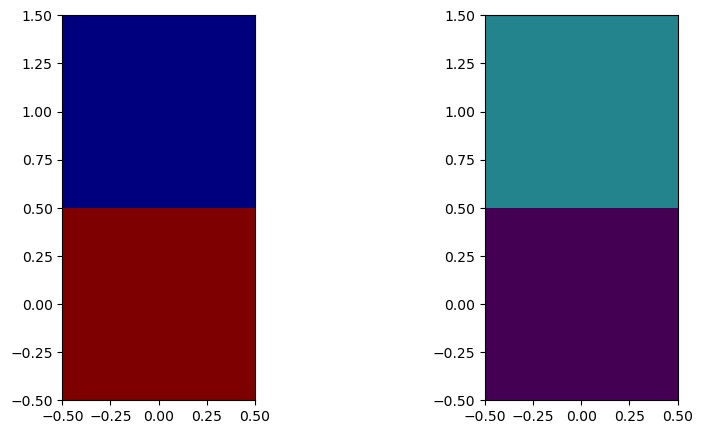

In [77]:
processor = VADProcessor()
processor.set_free_field_correction(7.8)
# processor.set_free_field_correction(4.2)
processor.set_preamplifier_gain(3.16/1000)
processor.set_sampling_period(timebase_to_sampling_period(0)) # setting a timebase of 0 yields a 0.1 us sampling period
processor.parse_file(f'./data/example.csv')
processor.plot()


print("Points: {} x {}  \nPeak pressure: {} Pa \nPhases: {} \nCoords:{}".format(  
        processor.x_size, 
        processor.z_size,
        processor.amplitudes,
        processor.phases,
        np.squeeze(( np.where(processor.amplitudes == np.amax(processor.amplitudes)) ) ) 
    )
)

# phases_outlet = []
# processor_phases = processor.phases
# print(processor_phases)
